In [4]:
#1st
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
#read in the pima-indians-diabetese.xlsx dataset
#read in the pima-indians-diabetese.xlsx dataset
#load data set and explore
aqDataSet_raw = pd.read_excel("AirQualityUCI.xlsx", header = 0)
# define a function called "outliers" which returns a list of index of outliers
#IQR = Q3 - Q1
#+/- 1.5 * IQR

def outliers(df,ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 -1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    ls = df.index[(df[ft] < lower_bound) | (df[ft] > upper_bound)]
    return ls

# create an empty list to store the output indices from multiple columns
aqDataSet_raw = pd.read_excel("AirQualityUCI.xlsx")
index_list = []
for feature in ["CO(GT)","PT08.S1(CO)","NMHC(GT)","C6H6(GT)","PT08.S2(NMHC)","NOx(GT)",
                "PT08.S3(NOx)","NO2(GT)","PT08.S4(NO2)","PT08.S5(O3)","T", "AH", "RH"]:
    index_list.extend(outliers(aqDataSet_raw, feature))
    
# define a function called "remove" which returns a cleanset dataframe without outliers

def remove(df,ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df

airQualityDataSet = remove(aqDataSet_raw, index_list)

airQualityDataSet.corr()["NO2(GT)"]

NO2_Concentration = airQualityDataSet["NO2(GT)"]
airQualityDataSet = airQualityDataSet.drop(["Date", "Time" , "NMHC(GT)","C6H6(GT)", "PT08.S3(NOx)","NO2(GT)" , "PT08.S4(NO2)", "T","RH","AH"], axis=1)
airQualityDataSet["NO2_Concentration"] = NO2_Concentration
airQualityDataSet


,CO(GT),PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S5(O3),NO2_Concentration
184,4.5,1616.50,1332.50,349.0,1818.50,150.0
185,2.8,1472.75,1126.50,224.0,1567.75,152.0
186,2.2,1378.50,1067.50,171.0,1373.50,139.0
187,2.2,1385.25,1056.25,149.0,1267.50,133.0
188,2.3,1378.75,1086.75,137.0,1143.50,126.0
...,...,...,...,...,...,...
9352,3.1,1314.25,1101.25,471.7,1728.50,189.8
9353,2.4,1162.50,1027.00,353.3,1269.00,179.2
9354,2.4,1142.00,1062.50,293.0,1092.00,174.7
9355,2.1,1002.50,960.50,234.5,769.75,155.7


In [47]:
#Lstm Technique for NO2 concentration prediction

import math
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

plt.style.use("fivethirtyeight")

X = airQualityDataSet[["CO(GT)","NOx(GT)","PT08.S5(O3)"]].values
Y = airQualityDataSet[["NO2_Concentration"]].values

#Train, test and split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

#Scale the all of the data to e values between 0 and 1
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
scaled_xtrain = x_scaler.fit_transform(X_train)
scaled_ytrain = y_scaler.fit_transform(y_train)
scaled_xtest = x_scaler.fit_transform(X_test)
#scaled_ytest = y_scaler.fit_transform(y_test)

#Convert to numpy arrays
scaled_xtrain, scaled_ytrain = np.array(scaled_xtrain), np.array(scaled_ytrain)

#Reshape the data into 3-D array
scaled_x = np.reshape(scaled_xtrain,(scaled_xtrain.shape[0],scaled_xtrain.shape[1],1))
#scaled_y = np.reshape(scaled_ytrain,(scaled_ytrain.shape[0],scaled_ytrain.shape[1]))


model_lstm = Sequential()

model_lstm.add(LSTM(units = 100, return_sequences = False, input_shape = (scaled_x.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units = 1))

#compile and fit the model on 40 epochs
optimizer = keras.optimizers.Adam(lr = 0.001)
model_lstm.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=['accuracy'])
lstm_history = model_lstm.fit(scaled_x, scaled_ytrain, epochs = 40, batch_size = 4, shuffle = True, validation_split = 0.20)




Train on 3496 samples, validate on 874 samples
Epoch 1/40
3496/3496 [==============================] - 8s 2ms/step - loss: 0.0180 - acc: 2.8604e-04 - val_loss: 0.0144 - val_acc: 0.0000e+00
Epoch 2/40
3496/3496 [==============================] - 6s 2ms/step - loss: 0.0139 - acc: 5.7208e-04 - val_loss: 0.0130 - val_acc: 0.0000e+00
Epoch 3/40
3496/3496 [==============================] - 5s 1ms/step - loss: 0.0125 - acc: 5.7208e-04 - val_loss: 0.0111 - val_acc: 0.0000e+00
Epoch 4/40
3496/3496 [==============================] - 5s 1ms/step - loss: 0.0118 - acc: 5.7208e-04 - val_loss: 0.0106 - val_acc: 0.0000e+00
Epoch 5/40
3496/3496 [==============================] - 6s 2ms/step - loss: 0.0116 - acc: 5.7208e-04 - val_loss: 0.0104 - val_acc: 0.0000e+00
Epoch 6/40
3496/3496 [==============================] - 4s 1ms/step - loss: 0.0112 - acc: 5.7208e-04 - val_loss: 0.0101 - val_acc: 0.0000e+00
Epoch 7/40
3496/3496 [==============================] - 6s 2ms/step - loss: 0.0113 - acc: 5.7208e-04 

In [48]:
# convert x_test to a numpy array
X_test = np.array(scaled_xtest)

In [49]:
#Reshape the data into 3-D array
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [50]:
#check predicted values
predictions = model_lstm.predict(X_test)
x_pred = model_lstm.predict(scaled_x)


In [51]:
#undo Scaling
predictions = y_scaler.inverse_transform(predictions)
x_pred = y_scaler.inverse_transform(x_pred)

In [52]:
predictions.shape


(1093, 1)

In [53]:
#calculate RMSE score

rmse_test = np.sqrt(np.mean(((predictions-y_test)**2)))
rmse_train = np.sqrt(np.mean(((x_pred-y_train)**2)))
print("Training RMSE" , rmse_train)
print("Testing  RMSE" , rmse_test)

Training RMSE 25.929299690542084
Testing  RMSE 26.396983916846274


In [54]:
#List all the data in the history
print(lstm_history.history.keys())
print("\n")


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])




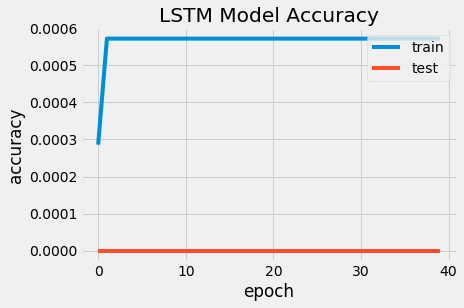

In [55]:
#Summarize History for Accuracy
plt.plot(lstm_history.history['acc'])
plt.plot(lstm_history.history['val_acc'])
plt.title('LSTM Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper right')
plt.show()

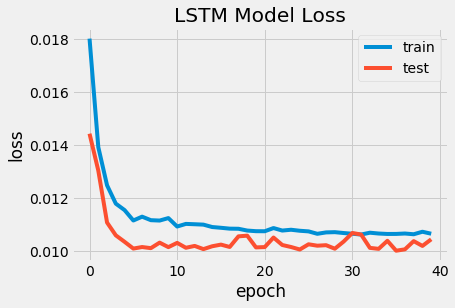

In [56]:
#Summarize History for Accuracy
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper right')
plt.show()

In [67]:
#2nd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
#read in the pima-indians-diabetese.xlsx dataset
#read in the pima-indians-diabetese.xlsx dataset
#load data set and explore
aqDataSet_raw = pd.read_excel("AirQualityUCI.xlsx", header = 0)
# define a function called "outliers" which returns a list of index of outliers
#IQR = Q3 - Q1
#+/- 1.5 * IQR

def outliers(df,ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 -1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    ls = df.index[(df[ft] < lower_bound) | (df[ft] > upper_bound)]
    return ls

# create an empty list to store the output indices from multiple columns
aqDataSet_raw = pd.read_excel("AirQualityUCI.xlsx")
index_list = []
for feature in ["CO(GT)","PT08.S1(CO)","NMHC(GT)","C6H6(GT)","PT08.S2(NMHC)","NOx(GT)",
                "PT08.S3(NOx)","NO2(GT)","PT08.S4(NO2)","PT08.S5(O3)","T", "AH", "RH"]:
    index_list.extend(outliers(aqDataSet_raw, feature))
    
# define a function called "remove" which returns a cleanset dataframe without outliers

def remove(df,ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df

airQualityDataSet = remove(aqDataSet_raw, index_list)

airQualityDataSet.corr()["NO2(GT)"]

NO2_Concentration = airQualityDataSet["NO2(GT)"]
airQualityDataSet = airQualityDataSet.drop(["Date", "Time" , "NMHC(GT)","C6H6(GT)", "PT08.S3(NOx)","NO2(GT)" , "PT08.S4(NO2)", "T","RH","AH"], axis=1)
airQualityDataSet["NO2_Concentration"] = NO2_Concentration
airQualityDataSet


,CO(GT),PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S5(O3),NO2_Concentration
184,4.5,1616.50,1332.50,349.0,1818.50,150.0
185,2.8,1472.75,1126.50,224.0,1567.75,152.0
186,2.2,1378.50,1067.50,171.0,1373.50,139.0
187,2.2,1385.25,1056.25,149.0,1267.50,133.0
188,2.3,1378.75,1086.75,137.0,1143.50,126.0
...,...,...,...,...,...,...
9352,3.1,1314.25,1101.25,471.7,1728.50,189.8
9353,2.4,1162.50,1027.00,353.3,1269.00,179.2
9354,2.4,1142.00,1062.50,293.0,1092.00,174.7
9355,2.1,1002.50,960.50,234.5,769.75,155.7


In [68]:
#GRU Technique for NO2 concentration prediction

import numpy as np
import pandas as pd
import keras
from math import sqrt
from numpy import concatenate
from pandas import DataFrame
from pandas import concat
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
import tensorflow as tf
from datetime import datetime


X = airQualityDataSet[["CO(GT)","NOx(GT)","PT08.S5(O3)"]].values
Y = airQualityDataSet[["NO2_Concentration"]].values

#Train, test and split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

#Scale the all of the data to e values between 0 and 1
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
scaled_xtrain = x_scaler.fit_transform(X_train)
scaled_ytrain = y_scaler.fit_transform(y_train)
scaled_xtest = x_scaler.fit_transform(X_test)
#scaled_ytest = y_scaler.fit_transform(y_test)

#Convert to numpy arrays
scaled_xtrain, scaled_ytrain = np.array(scaled_xtrain), np.array(scaled_ytrain)

#Reshape the data into 3-D array
scaled_x = np.reshape(scaled_xtrain,(scaled_xtrain.shape[0],scaled_xtrain.shape[1],1))
#scaled_y = np.reshape(scaled_ytrain,(scaled_ytrain.shape[0],scaled_ytrain.shape[1],1))


model_gru = Sequential()

model_gru.add(GRU(100, return_sequences = False, input_shape = (scaled_x.shape[1], 1)))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(units = 1))

#compile and fit the model on 40 epochs
optimizer = keras.optimizers.Adam(lr = 0.0001)
model_gru.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=['accuracy'])
gru_history = model_gru.fit(scaled_x, scaled_ytrain, epochs = 40, batch_size = 4, shuffle = True, validation_split = 0.20)


Train on 3496 samples, validate on 874 samples
Epoch 1/40
3496/3496 [==============================] - 6s 2ms/step - loss: 0.0331 - acc: 5.7208e-04 - val_loss: 0.0137 - val_acc: 0.0000e+00
Epoch 2/40
3496/3496 [==============================] - 4s 1ms/step - loss: 0.0149 - acc: 5.7208e-04 - val_loss: 0.0136 - val_acc: 0.0000e+00
Epoch 3/40
3496/3496 [==============================] - 3s 976us/step - loss: 0.0147 - acc: 5.7208e-04 - val_loss: 0.0137 - val_acc: 0.0000e+00
Epoch 4/40
3496/3496 [==============================] - 3s 964us/step - loss: 0.0146 - acc: 5.7208e-04 - val_loss: 0.0134 - val_acc: 0.0000e+00
Epoch 5/40
3496/3496 [==============================] - 4s 1ms/step - loss: 0.0143 - acc: 5.7208e-04 - val_loss: 0.0133 - val_acc: 0.0000e+00
Epoch 6/40
3496/3496 [==============================] - 5s 1ms/step - loss: 0.0141 - acc: 5.7208e-04 - val_loss: 0.0132 - val_acc: 0.0000e+00
Epoch 7/40
3496/3496 [==============================] - 4s 1ms/step - loss: 0.0140 - acc: 5.7208e

In [69]:
# convert x_test to a numpy array
X_test = np.array(scaled_xtest)
#Reshape the data into 3-D array
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [70]:
#check predicted values
predictions = model_gru.predict(X_test)
x_pred = model_gru.predict(scaled_x)

In [71]:
#undo Scaling
predictions = y_scaler.inverse_transform(predictions)
x_pred = y_scaler.inverse_transform(x_pred)

In [72]:
#calculate RMSE score

rmse_test = np.sqrt(np.mean(((predictions-y_test)**2)))
rmse_train = np.sqrt(np.mean(((x_pred-y_train)**2)))
print("Training RMSE" , rmse_train)
print("Testing  RMSE" , rmse_test)

Training RMSE 25.888376040131085
Testing  RMSE 26.65601273798871


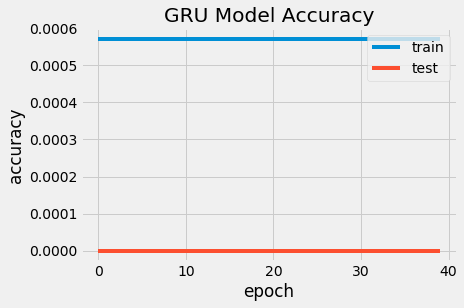

In [75]:
#Summarize History for Accuracy
plt.plot(gru_history.history['acc'])
plt.plot(gru_history.history['val_acc'])
plt.title('GRU Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper right')
plt.show()

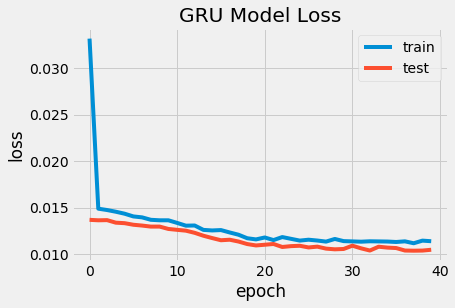

In [76]:
#Summarize History for Accuracy
plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'])
plt.title('GRU Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper right')
plt.show()

In [77]:
#3RD

#2nd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
#read in the pima-indians-diabetese.xlsx dataset
#read in the pima-indians-diabetese.xlsx dataset
#load data set and explore
aqDataSet_raw = pd.read_excel("AirQualityUCI.xlsx", header = 0)
# define a function called "outliers" which returns a list of index of outliers
#IQR = Q3 - Q1
#+/- 1.5 * IQR

def outliers(df,ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 -1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    ls = df.index[(df[ft] < lower_bound) | (df[ft] > upper_bound)]
    return ls

# create an empty list to store the output indices from multiple columns
aqDataSet_raw = pd.read_excel("AirQualityUCI.xlsx")
index_list = []
for feature in ["CO(GT)","PT08.S1(CO)","NMHC(GT)","C6H6(GT)","PT08.S2(NMHC)","NOx(GT)",
                "PT08.S3(NOx)","NO2(GT)","PT08.S4(NO2)","PT08.S5(O3)","T", "AH", "RH"]:
    index_list.extend(outliers(aqDataSet_raw, feature))
    
# define a function called "remove" which returns a cleanset dataframe without outliers

def remove(df,ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df

airQualityDataSet = remove(aqDataSet_raw, index_list)

airQualityDataSet.corr()["NO2(GT)"]

NO2_Concentration = airQualityDataSet["NO2(GT)"]
airQualityDataSet = airQualityDataSet.drop(["Date", "Time" , "NMHC(GT)","C6H6(GT)", "PT08.S3(NOx)","NO2(GT)" , "PT08.S4(NO2)", "T","RH","AH"], axis=1)
airQualityDataSet["NO2_Concentration"] = NO2_Concentration
airQualityDataSet

,CO(GT),PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S5(O3),NO2_Concentration
184,4.5,1616.50,1332.50,349.0,1818.50,150.0
185,2.8,1472.75,1126.50,224.0,1567.75,152.0
186,2.2,1378.50,1067.50,171.0,1373.50,139.0
187,2.2,1385.25,1056.25,149.0,1267.50,133.0
188,2.3,1378.75,1086.75,137.0,1143.50,126.0
...,...,...,...,...,...,...
9352,3.1,1314.25,1101.25,471.7,1728.50,189.8
9353,2.4,1162.50,1027.00,353.3,1269.00,179.2
9354,2.4,1142.00,1062.50,293.0,1092.00,174.7
9355,2.1,1002.50,960.50,234.5,769.75,155.7


In [41]:
#CNN Technique for NO2 concentration prediction

import numpy as np
import pandas as pd
import math 
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



X = airQualityDataSet[["CO(GT)","NOx(GT)","PT08.S5(O3)"]].values
Y = airQualityDataSet[["NO2_Concentration"]].values

#Train, test and split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)


#Convert to numpy arrays
xtrain, ytrain = np.array(X_train), np.array(y_train)

#Reshape the data into 3-D array
scaled_x = np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],1))
#scaled_y = np.reshape(ytrain,(ytrain.shape[0],ytrain.shape[1],1))


model_cnn = Sequential()

model_cnn.add(Conv1D(filters = 64, kernel_size = 2, activation = 'relu', input_shape = (scaled_x.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size = 2))
model_cnn.add(Flatten())
model_cnn.add(Dense(100, activation = 'relu'))
model_cnn.add(Dense(1))
model_cnn.compile(optimizer = 'adam', loss = 'mse', metrics=['accuracy'])

#fit the model on 40 epochs
cnn_history = model_cnn.fit(scaled_x, ytrain, epochs = 200, verbose = 1, validation_split = 0.20)



Train on 3496 samples, validate on 874 samples
Epoch 1/200
3496/3496 [==============================] - 2s 506us/step - loss: 1694.3143 - acc: 0.0086 - val_loss: 1109.3889 - val_acc: 0.0137
Epoch 2/200
3496/3496 [==============================] - 0s 81us/step - loss: 1062.0231 - acc: 0.0117 - val_loss: 1112.1468 - val_acc: 0.0114
Epoch 3/200
3496/3496 [==============================] - 0s 84us/step - loss: 1055.0307 - acc: 0.0123 - val_loss: 1100.8498 - val_acc: 0.0137
Epoch 4/200
3496/3496 [==============================] - 0s 73us/step - loss: 1074.1309 - acc: 0.0117 - val_loss: 1108.6801 - val_acc: 0.0172
Epoch 5/200
3496/3496 [==============================] - 0s 61us/step - loss: 1058.1542 - acc: 0.0097 - val_loss: 1120.5706 - val_acc: 0.0183
Epoch 6/200
3496/3496 [==============================] - 0s 56us/step - loss: 1050.8481 - acc: 0.0132 - val_loss: 1106.2740 - val_acc: 0.0172
Epoch 7/200
3496/3496 [==============================] - 0s 69us/step - loss: 1066.7542 - acc: 0.009

3496/3496 [==============================] - 0s 73us/step - loss: 682.0096 - acc: 0.0163 - val_loss: 781.0971 - val_acc: 0.0160
Epoch 117/200
3496/3496 [==============================] - 0s 74us/step - loss: 697.0151 - acc: 0.0180 - val_loss: 744.2402 - val_acc: 0.0149
Epoch 118/200
3496/3496 [==============================] - 0s 61us/step - loss: 687.0708 - acc: 0.0149 - val_loss: 804.4556 - val_acc: 0.0149
Epoch 119/200
3496/3496 [==============================] - 0s 65us/step - loss: 676.4692 - acc: 0.0140 - val_loss: 777.7044 - val_acc: 0.0172
Epoch 120/200
3496/3496 [==============================] - 0s 66us/step - loss: 688.8343 - acc: 0.0146 - val_loss: 767.2321 - val_acc: 0.0160
Epoch 121/200
3496/3496 [==============================] - 0s 54us/step - loss: 707.3395 - acc: 0.0140 - val_loss: 771.8188 - val_acc: 0.0183
Epoch 122/200
3496/3496 [==============================] - 0s 74us/step - loss: 700.8690 - acc: 0.0163 - val_loss: 855.2208 - val_acc: 0.0126
Epoch 123/200
3496/3

Epoch 174/200
3496/3496 [==============================] - 0s 50us/step - loss: 661.5332 - acc: 0.0174 - val_loss: 765.4553 - val_acc: 0.0103
Epoch 175/200
3496/3496 [==============================] - 0s 47us/step - loss: 658.2853 - acc: 0.0186 - val_loss: 721.2793 - val_acc: 0.0172
Epoch 176/200
3496/3496 [==============================] - 0s 50us/step - loss: 662.2496 - acc: 0.0154 - val_loss: 713.1797 - val_acc: 0.0126
Epoch 177/200
3496/3496 [==============================] - 0s 59us/step - loss: 648.7699 - acc: 0.0166 - val_loss: 709.0244 - val_acc: 0.0195
Epoch 178/200
3496/3496 [==============================] - 0s 102us/step - loss: 659.2608 - acc: 0.0183 - val_loss: 727.3282 - val_acc: 0.0126
Epoch 179/200
3496/3496 [==============================] - 0s 45us/step - loss: 662.4869 - acc: 0.0134 - val_loss: 781.4031 - val_acc: 0.0217
Epoch 180/200
3496/3496 [==============================] - 0s 52us/step - loss: 652.4060 - acc: 0.0174 - val_loss: 719.5409 - val_acc: 0.0126
Epoch

In [42]:
# convert x_test to a numpy array
X_test = np.array(X_test)
#Reshape the data into 3-D array
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [43]:
#check predicted values
predictions = model_cnn.predict(X_test, verbose = 0)
x_pred = model_cnn.predict(scaled_x,verbose = 0 )

In [44]:
#calculate RMSE score
rmse_test = np.sqrt(np.mean(((predictions-y_test)**2)))
rmse_train = np.sqrt(np.mean(((x_pred-y_train)**2)))
print("Training RMSE" , rmse_train)
print("Testing  RMSE" , rmse_test)

Training RMSE 25.682184148857047
Testing  RMSE 26.298570257598374


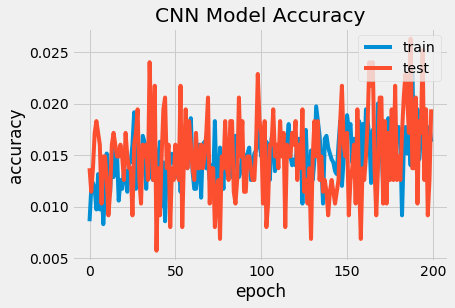

In [45]:
#Summarize History for Accuracy
plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])
plt.title('CNN Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper right')
plt.show()

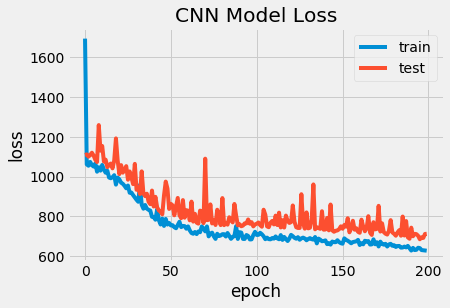

In [46]:

#Summarize History for Accuracy
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper right')
plt.show()